In [1]:
from matplotlib import pyplot as plt
from pprint import pprint
import numpy as np

dataName = '180710_HAECs_NoFlow_HAEC2\sample1'
#dataName = 'test_data'

dataOrganization = 'Culture_16bits'
codebook = 'HAEC1E1'

from merlin.core import dataset
from merlin.core import executor
from merlin.core import scheduler

import json

dSet = dataset.MERFISHDataSet(
        dataName, 
        dataOrganizationName=dataOrganization,
        codebookName=codebook)

e = executor.LocalExecutor()

with open('test_analysis_parameters.json', 'r') as f:
    s = scheduler.Scheduler(dSet, e, json.load(f))

C:\Users\George\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
taskNames = list(s.analysisTasks.keys())
pprint(taskNames)
s.analysisTasks['SegmentCells'].get_dependencies()

['FiducialCorrelationWarp',
 'DeconvolutionPreprocess',
 'Optimize',
 'Decode',
 'SimpleGlobalAlignment',
 'GenerateMosaic',
 'PlotPerformance',
 'FilterBarcodes',
 'SegmentCells',
 'CleanCellSegmentation']


['FiducialCorrelationWarp', 'SimpleGlobalAlignment']

In [3]:
b = s.analysisTasks['FiducialCorrelationWarp'].run()
b = s.analysisTasks['SimpleGlobalAlignment'].run()
b = s.analysisTasks['SegmentCells'].run()

AnalysisAlreadyStartedException: 

In [ ]:
temp = s.analysisTasks['CleanCellSegmentation'].run_analysis()


In [18]:
temp = s.analysisTasks['CleanCellSegmentation'].get_cell_boundaries()
im = np.array([[s.analysisTasks['CleanCellSegmentation'].get_cell_containing_position(y, x) for x in range(200)] for y in range(100)])

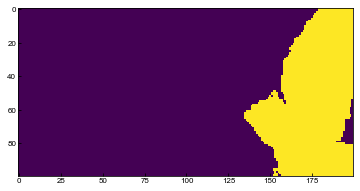

In [30]:
plt.imshow(im==1951)

In [21]:
np.unique(im)

array([  -1, 1753, 1754, 1943, 1945, 1946, 1948, 1949, 1951])

In [7]:
def plot_boundary(c, highlight=False):
    if not highlight:
        plt.plot([x[0] for x in c], [x[1] for x in c], 'k')
    else:
        plt.plot([x[0] for x in c], [x[1] for x in c], 'r')
    
from shapely import geometry
import rtree

cellPolygons = [geometry.Polygon(x).buffer(0) for x in b]
cellPolygons = [p for p in cellPolygons if p.area>0]

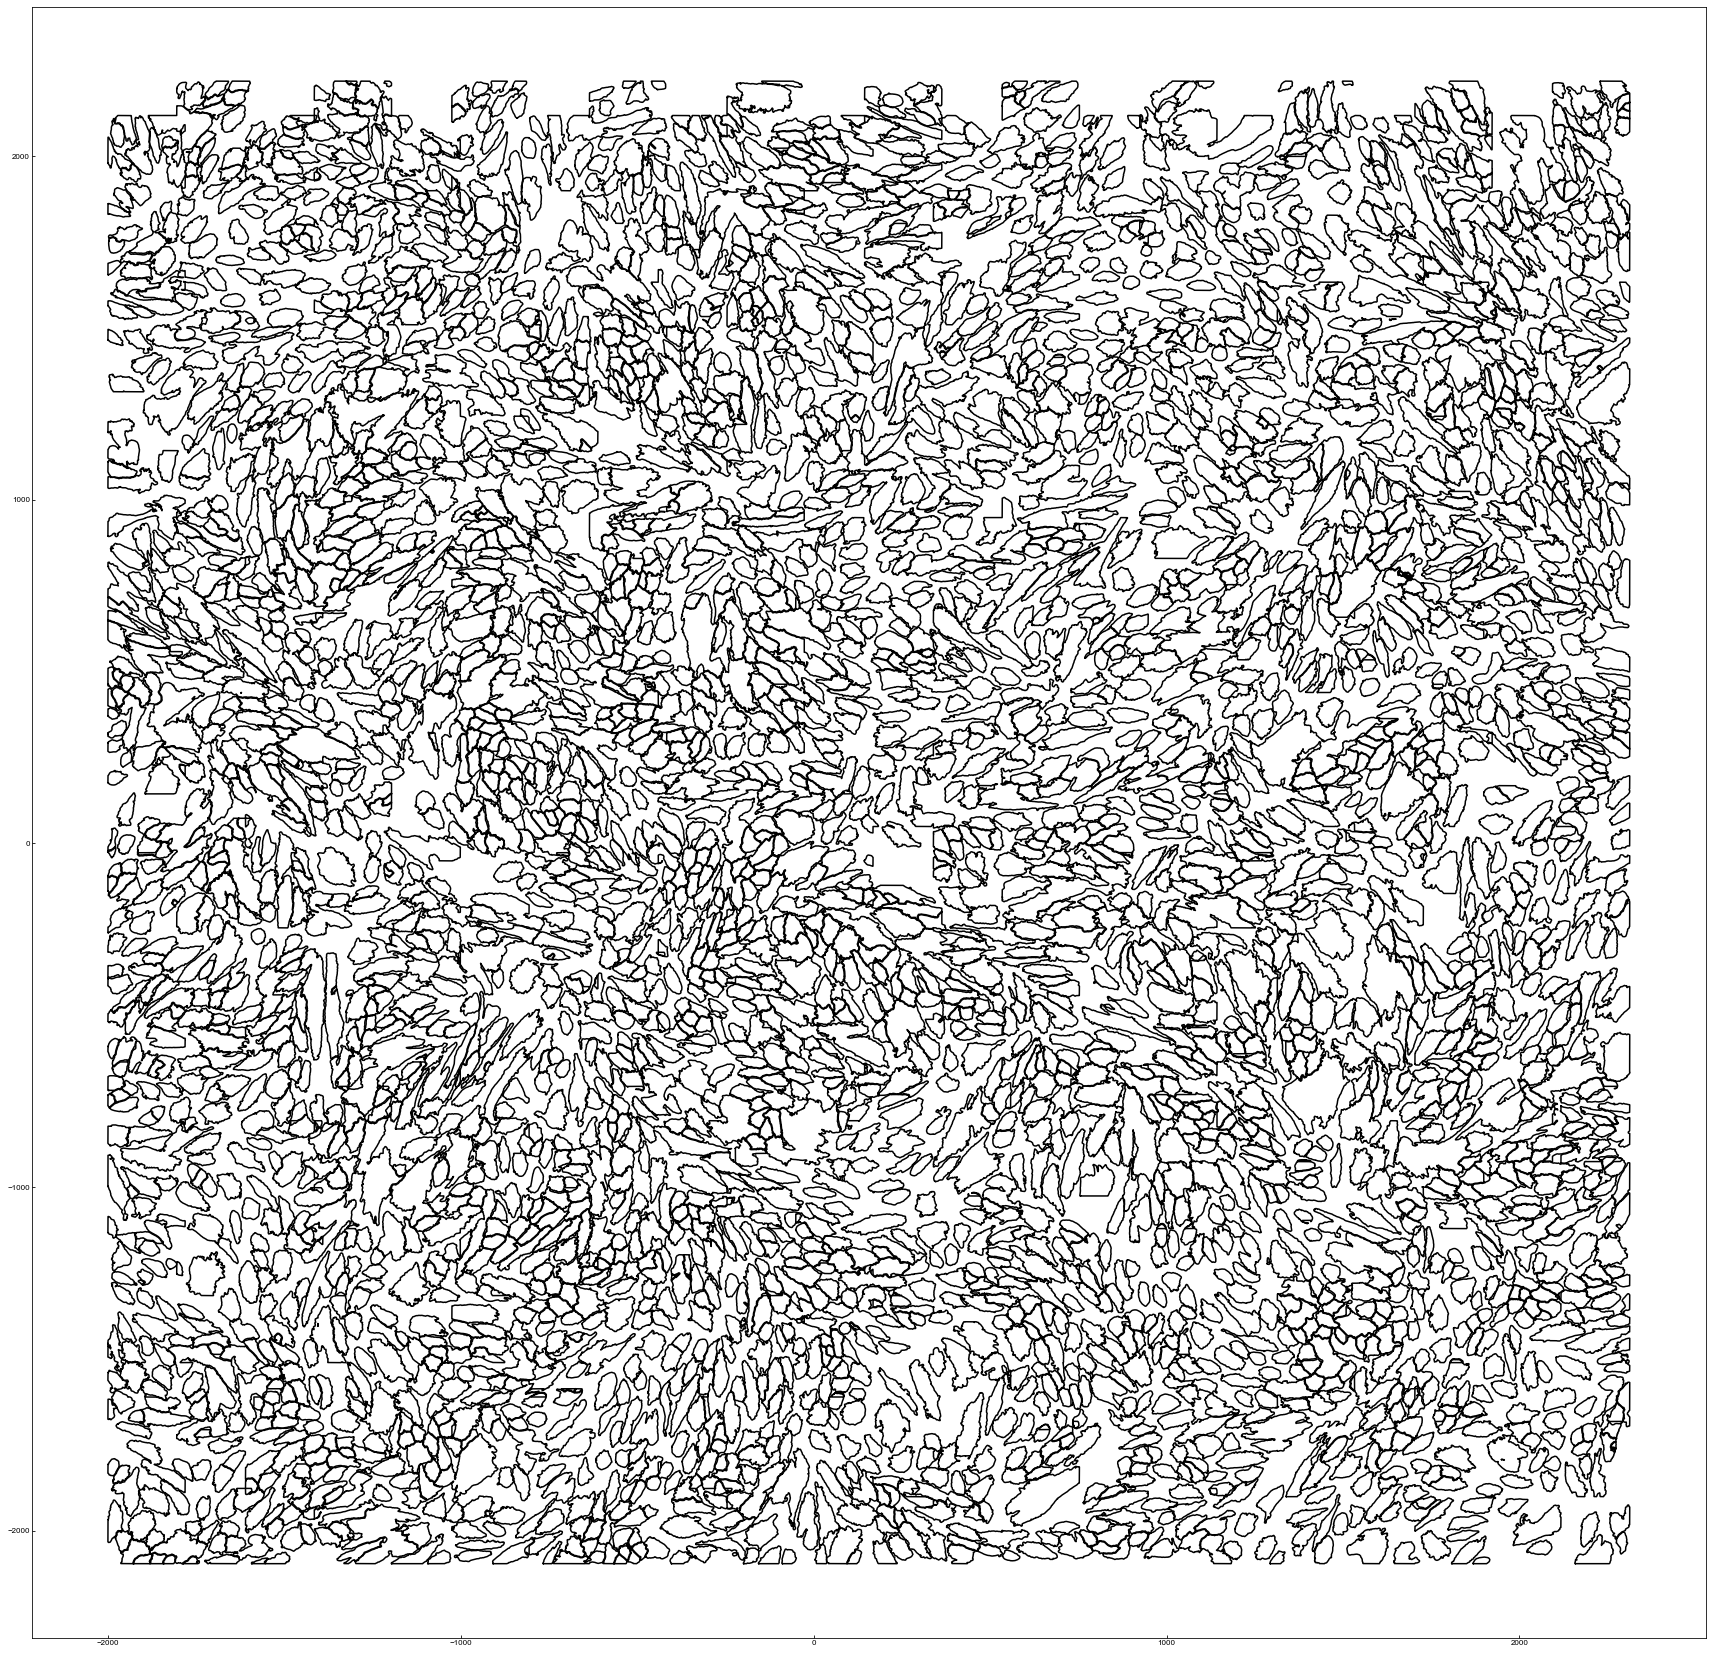

In [9]:
plt.figure(figsize=(30,30))
p = [plot_boundary(x) for x in temp]

In [6]:
import networkx

def get_intersection_graph(polygonList, areaThreshold=250):
    polygonIndex = rtree.index.Index()
    intersectGraphEdges = [[i,i] for i in range(len(polygonList))]
    for i,cell in enumerate(polygonList):
        putativeIntersects = list(polygonIndex.intersection(cell.bounds))

        if len(putativeIntersects) > 0:
            intersectGraphEdges += [[i, j] for j in putativeIntersects if cell.intersection(polygonList[j]).area>areaThreshold] 
            intersectGraphEdges += [[i, j] for j in putativeIntersects if cell.within(polygonList[j])] 
            intersectGraphEdges += [[i, j] for j in putativeIntersects if polygonList[j].within(cell)] 

        polygonIndex.insert(i, cell.bounds)

    intersectionGraph = networkx.Graph()
    intersectionGraph.add_edges_from(intersectGraphEdges)
    return intersectionGraph

In [7]:

from shapely.ops import unary_union

components = list(networkx.connected_components(get_intersection_graph(cellPolygons)))
print(len(components))
mergedCells = [unary_union([cellPolygons[i] for i in c]).buffer(1) for c in components]
print(len(mergedCells))

3969
3969


In [15]:
sg = get_intersection_graph(mergedCells, areaThreshold=0)
sg2 = s.analysisTasks['CleanCellSegmentation']._get_intersection_graph(mergedCells, areaThreshold=0)

In [68]:
cleanedCells = []

for i, currentCell in enumerate(mergedCells[:5]):
    edgesFromCell = sg.edges(i)
    
    cleanedCell = geometry.Polygon(currentCell)
    for edge in edgesFromCell:
        if edge[1] == i:
            pass
        cleanedCell = cleanedCell.symmetric_difference(mergedCells[edge[1]]).difference(mergedCells[edge[1]])

    cleanedCells.append(cleanedCell)

In [147]:
cleanedCells2 = []

def clean_polygon(inputPolygon):
    if inputPolygon.geom_type == 'Polygon':
        return inputPolygon
    elif inputPolygon.geom_type == 'MultiPolygon':
        return inputPolygon[np.argmax([x.area for x in inputPolygon])]
    else:
        return None
    

for i, currentCell in enumerate(mergedCells):
    edgesFromCell = sg.edges(i)
    
    cleanedCell = geometry.Polygon(currentCell)
    for edge in edgesFromCell:
        if edge[0] != edge[1] and cleanedCell is not None:
            if not mergedCells[edge[1]].within(cleanedCell):
                cleanedCell = clean_polygon(s.analysisTasks['CleanCellSegmentation']._subtract_region(cleanedCell, mergedCells[edge[1]]))

    if cleanedCell is not None:
        cleanedCells2.append(cleanedCell)

In [138]:
i = 80
mergedCells[i]
edges = sg.edges(i)
print(sg2.edges(i))
cleanedCell = geometry.Polygon(mergedCells[i])
print(edges)
s1 = mergedCells[79]
for edge in edges:
    if edge[1] != 0:
        print(edge)
        cleanedCell = s.analysisTasks['CleanCellSegmentation']._subtract_region(cleanedCell, mergedCells[edge[1]])

[(80, 80), (80, 79), (80, 81)]
[(80, 80), (80, 79), (80, 81)]
(80, 80)
(80, 79)
(80, 81)


In [149]:
len(cleanedCells2)

3939

In [144]:
mergedCells[i].within(s1)

True

In [143]:
s.analysisTasks['CleanCellSegmentation']._subtract_region(mergedCells[i], s1)

In [4]:
plt.figure(figsize=(30,30))
p = [plot_boundary(a.exterior.coords) for a in temp]

TypeError: 'NoneType' object is not iterable

<Figure size 2160x2160 with 0 Axes>

In [112]:
ax = [x for x in assembledCells if x.geom_type=='MultiPolygon']

In [4]:
plt.figure(figsize=(30,30))
p = [plot_boundary(a.exterior.coords) for a in temp]

NameError: name 'plot_boundary' is not defined

<Figure size 2160x2160 with 0 Axes>

In [94]:
components[2]

{2, 6097, 6109}

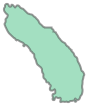

In [98]:
u = cascaded_union([cellPolygons[2], cellPolygons[6097], cellPolygons[6109]])

u

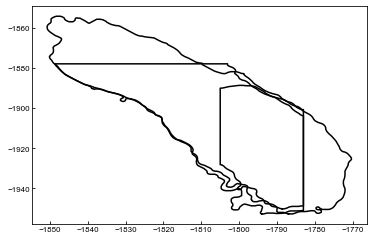

In [95]:
p = [plot_boundary(cellPolygons[i].exterior.coords) for i in (2,6097, 6109)]

In [ ]:
dSet.load_analysis_result('cell_boundaries', 'SegmentCells', resultIndex=0).dtype

In [26]:
print([range(100)])

[range(0, 100)]


In [36]:
cellPolygons[3738].area

6139.794076996877

In [182]:
np.array(cellPolygons[7].exterior.coords)

array([[-1988.02200014, -1838.8800019 ],
       [-1988.97600013, -1838.56200191],
       [-1989.50600012, -1838.45600191],
       [-1990.14200012, -1838.45600191],
       [-1990.88400011, -1838.56200191],
       [-1991.5200001 , -1838.7740019 ],
       [-1992.26200009, -1838.7740019 ],
       [-1992.47400009, -1838.66800191],
       [-1993.11000008, -1838.03200191],
       [-1993.11000008, -1837.92600191],
       [-1993.64000008, -1837.39600192],
       [-1993.85200007, -1837.29000192],
       [-1994.27600007, -1837.18400192],
       [-1995.23000006, -1837.29000192],
       [-1995.76000005, -1837.29000192],
       [-1996.18400005, -1837.18400192],
       [-1996.60800004, -1836.97200193],
       [-1996.82000004, -1836.76000193],
       [-1996.92600004, -1836.54800193],
       [-1997.03200004, -1836.33600193],
       [-1997.13800003, -1836.01800194],
       [-1997.24400003, -1835.06400195],
       [-1997.56200003, -1834.42800196],
       [-1997.88000003, -1834.00400196],
       [-1999.25